## Assignment_1_Solutions for Homework_5
### aes807

#### Problem Statement :
    - Test whether a gaussian model N($\mu$, $\sigma$) for the age distribution of citibike drivers is a sensible
      model, or if you can find a better fit with another distribution.
    - Use 2 tests: KS, AD, KL, chisq (even though we have not talked about it in detail yet) to do this.
    - Test at the Normal and a least one other distributions (e.g. Poisson, or Binomial, or Chisq, Lognormal.......)

In [4]:
import datetime 
import calendar

my_date = datetime.datetime(2016, 10 , 10)
calendar.day_name[my_date.weekday()]

'Monday'

In [97]:
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import csv

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
            os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [19]:
datestring = '201505'
getCitiBikeCSV(datestring)

('Downloading', '201505')
file in place, you can continue


In [20]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df.head()

tripduration          starttime           stoptime  start station id  \
0           415  5/1/2015 00:00:11  5/1/2015 00:07:06               477   
1          1523  5/1/2015 00:00:28  5/1/2015 00:25:52               293   
2           642  5/1/2015 00:00:52  5/1/2015 00:11:35               380   
3           367  5/1/2015 00:00:48  5/1/2015 00:06:55               537   
4          2734  5/1/2015 00:00:51  5/1/2015 00:46:26               426   

        start station name  start station latitude  start station longitude  \
0          W 41 St & 8 Ave               40.756405               -73.990026   
1    Lafayette St & E 8 St               40.730287               -73.990765   
2         W 4 St & 7 Ave S               40.734011               -74.002939   
3  Lexington Ave & E 24 St               40.740259               -73.984092   
4    West St & Chambers St               40.717548               -74.013221   

   end station id          end station name  end station latitude  \
0             442           W 27 St & 7 Ave             40.746647   
1             324   DeKalb Ave & Hudson Ave             40.689888   
2             507           E 25 St & 2 Ave             40.739126   
3             280           E 10 St & 5 Ave             40.733320   
4             327  Vesey Pl & River Terrace             40.715338   

   end station longitude  bikeid    usertype  birth year  gender  
0             -73.993915   17012  Subscriber      1981.0       1  
1             -73.981013   17390    Customer         NaN       0  
2             -73.979738   15003  Subscriber      1990.0       1  
3             -73.995101   14788  Subscriber      1978.0       1  
4             -74.016584   21068  Subscriber      1956.0       2

In [21]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [24]:
df['age'] = 2015 - df['birth year'][(df['usertype'] == 'Subscriber')]
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'age'],
      dtype='object')

In [72]:
df_age = df.age
df_age.dropna(inplace= True)

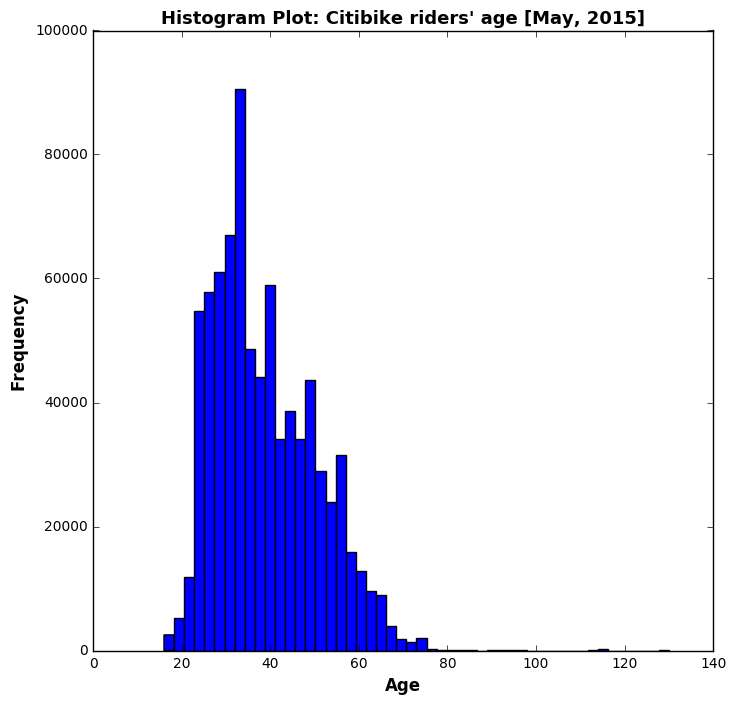

In [77]:
plt.figure(figsize=(8,8))
plt.hist(df_age,50)
plt.xlabel("Age", fontweight = 'bold', size = 12)
plt.ylabel('Frequency', fontweight = 'bold', size = 12)
plt.title("Histogram Plot: Citibike riders' age [May, 2015]", fontweight = 'bold',size=13)
plt.show()

Mean: 38.7492617385 Sigma: 11.4588157719


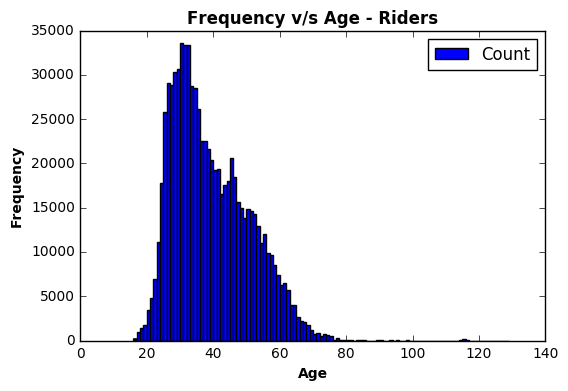

In [108]:
print 'Mean:', df.age.mean(), 'Sigma:', df.age.std()
                                                                                            
bins = np.arange(df.age.min(), df.age.max(), 1)
plt.hist(df.age, bins, label='Count')
plt.title('Frequency v/s Age - Riders', fontweight = 'bold')
plt.xlabel('Age', fontweight = 'bold')
plt.ylabel('Frequency', fontweight = 'bold')
plt.legend()
plt.show()

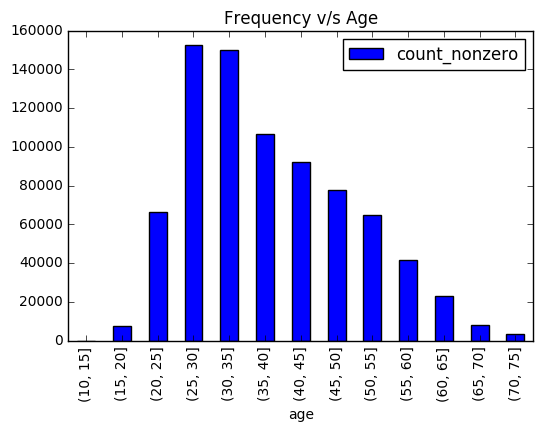

In [106]:
bins = np.arange(10,80,5)
plot = df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero])\
.plot(kind='bar', legend=True, title = 'Frequency v/s Age')

# -------------------------------------------------------

# Using the Normal Distribution

## $H_0 => F_a - F_G = 0$
##### Null hypothesis: The ages of citibike users are drawn from a Gaussian Distribution.
## $H_a => F_a - F_G != 0$
##### Alternate Hypothesis: The ages of citibike users are not drawn from a Gaussian Distribution

### Significance Level = 0.05 / 5%
### $F_a$ = F_Age
### $F_G$ = F_Gaussian

# -------------------------------------------------------

# Using the KS-Test

# KS-Test with Normal Distribution

##### First entry is (rvs) which is the observations that we are trying to determine the distribution of
##### CDF is normal distribution here
##### A standard normal will have a mean = 0
##### Standard Deviation = 1

In [65]:
scipy.stats.kstest?

In [66]:
scipy.stats.kstest(df['age'].values,'norm', args=(df.age.mean(), df.age.std()))

KstestResult(statistic=0.10248543296647195, pvalue=0.0)

#### Here, the p-value is coming up to 0.0

#### The significance value we have set is 0.05, hence we reject the Null Hypothesis that the distribution of the CitiBike users is drawn from the Normal/Gaussian Distribution

# Using the Chi-Square Test

# Chi-Square Test with Normal Distribution

In [109]:
scipy.stats.chisquare(df['age'].values)

Power_divergenceResult(statistic=2691989.2279713918, pvalue=0.0)

#### Here, the p-value is coming up to 0.0

#### The significance value we have set is 0.05, hence we reject the Null Hypothesis that the distribution of the CitiBike users is drawn from the Normal/Gaussian Distribution

#### Also, the statistic shown here is a very high number which is close to infinite and which entails that the counting is stopped

# -------------------------------------------------------

# Using the Logistic Distribution

## $H_0 => F_a - F_L = 0$
##### Null hypothesis: The ages of citibike users are drawn from a Logistic Distribution.
## $H_a => F_a - F_L != 0$
##### Alternate Hypothesis: The ages of citibike users are not drawn from a Logistic Distribution

### Significance Level = 0.05 / 5%
### $F_a$ = F_Age
### $F_L$ = F_Logistic

# -------------------------------------------------------

# Using Anderson-Darling Test

# Anderson-Darling Test with Logistic Distribution

In [110]:
# Anderson-Darling test is for data coming from a particular distribution
# Here we have used the Logistic Distribution
# First input is the array of sample data that we want to determine the distribution of
# Second input is the distribution that we are comparing the sample distribution to so as to find the good fit
scipy.stats.anderson(df['age'].values, dist='logistic')

AndersonResult(statistic=10391.35783835745, critical_values=array([ 0.426,  0.563,  0.66 ,  0.769,  0.906,  1.01 ]), significance_level=array([ 25. ,  10. ,   5. ,   2.5,   1. ,   0.5]))

#### For this Anderson test I have obtained a statistic of a high number, which it is going to stop counting because it is too high. 
#### My alpha is 0.05 which I have set as the significance level.
#### I am going to reject the H0 if it is above the third entry in the critical values -> 0.66. 
#### We reject the null hypotheses that ages of citibike riders are drawn from the logistic distribution.

# Using the KS-Test

# KS-Test with Logistic Distribution

##### First entry is (rvs) which is the observations that we are trying to determine the distribution of
##### CDF is logistic distribution here

In [111]:
scipy.stats.kstest(df['age'].values,'logistic', args=(df.age.mean(), df.age.std()))

KstestResult(statistic=0.17781816774797352, pvalue=0.0)

#### Here, the p-value is coming up to 0.0

#### The significance value we have set is 0.05, hence we reject the Null Hypothesis that the distribution of the CitiBike users is drawn from the Logistic Distribution